In [1]:
from PIL import ImageDraw, Image as PIL_Image
import struct
import numpy as np
import math
import matplotlib.pyplot as plt
import random

In [2]:
# Класс математических функций
class Function:
    # Конструктор класса
    #
    # start - начальное значение оси абсцисс
    # end - конечное значение оси абсцисс
    # step - шаг
    def __init__(self, start=None, end=None, step=None):
        if start is not None and end is not None and step is not None:
            self.initializeX(start, end, step)
            self.initializeY()
    
    # Инициализация оси абсцисс
    #
    # start - начальное значение оси абсцисс
    # end - конечное значение оси абсцисс
    # step - шаг
    def initializeX(self, start, end, step):
        self.start = start
        self.end = end
        self.step = step
        self.length = int(np.ceil(np.abs(end - start) / step))
        self.X = np.arange(start, end, step)
    
    # Инициализация оси ординат
    def initializeY(self):
        self.Y = np.zeros(self.length)
        
    # Функция экспоненты вида b*exp^(-a*x)
    def exp(self, a, b):
        self.Y = np.exp(-a * self.X) * b
        
    # Функция синусоиды
    #
    # A - амплитуда
    # f - частота
    def sin(self, A, f):
        self.Y = A * np.sin(2 * np.pi * f * self.X)
        
    # Функция сложной синусоиды
    #
    # arrA - массив амплитуд
    # arrF - массив частот
    def complex_sin(self, arrA, arrF):
        for i in range(0, len(arrA)):
            self.Y += arrA[i] * np.sin(2 * np.pi * arrF[i] * self.X)
        
    # Функция случайного шума
    #
    # scale - диапазон шума
    def rand(self, scale):
        self.Y = np.array([random.uniform(-scale, scale) for _ in range(0, self.length)])
        
    # Метод произведения функций
    #
    # arrFunc - массив функций
    def multiply_func(self, arrFunc):
        self.Y = 1
        for i in range(0, len(arrFunc)):
            self.Y *= arrFunc[i].Y.copy()
       
    # Метод свёртки функций
    def convolution_func(self, x, h):
        N = x.length
        M = h.length
        self.Y = np.zeros(N + M) # меняем количесвто значений функции
        for k in range(0, N + M):
            sum = 0
            for j in range(0, M):
                try:
                    sum += x.Y[k - j] * h.Y[j]
                except:
                    sum += 0
            self.Y[k] = sum
        self.Y = np.array(list(self.Y)[: len(self.Y) - M]) # удаляем справа M значений
     
    # Метод преобразований Фурье
    #
    # func - исходная функция
    # window - окно [0..1]
    # kind - тип преобразования
    ## kind = 1 - Амплитудный спектр Фурье
    ## kind = 2 - Прямое преобразование Фурье
    ## kind = 3 - Обратное преобразование Фурье
    # freq - привести шкалу абсцисс к [Гц]
    # half - отобразить половину шкалы
    # dt - шаг дискретизации
    def fourier_transform(self, func, window, kind=1, freq=False, half=False, dt=1):
        lenZeros = int(func.length * (1 - window) / 2)
        for i in range(0, lenZeros):
            func.Y[i] = 0
            func.Y[N - i - 1] = 0
        sumRe, sumIm = 0, 0
        for k in range(0, func.length):
            sumRe += func.Y[k] * np.cos(2 * np.pi * self.X * k / func.length)
            sumIm += func.Y[k] * np.sin(2 * np.pi * self.X * k / func.length)
        Re = (1 / func.length) * sumRe
        Im = (1 / func.length) * sumIm
        if kind == 1:
            self.Y = (Re ** 2 + Im ** 2) ** 0.5
        elif kind == 2:
            self.Y = Re + Im
        else:
            self.Y = sumRe + sumIm
        if freq:
            # переходим от параметра n к f
            df = 1 / (self.end * dt)
            self.initializeX(self.start, self.end * df, df)
        if half:
            # берём первую половину графика
            self.initializeX(self.start, int(self.end / 2), self.step)
            self.Y = np.array(list(self.Y)[:self.length])
          
    # Метод восстановления функции
    #
    # func1 - исходная функция
    # func2 - искажающая функция
    # alpha - параметр [0..1]
    def recover(self, func1, func2, alpha2=0):
        sumRe1, sumIm1 = 0, 0
        sumRe2, sumIm2 = 0, 0
        for k in range(0, func1.length):
            sumRe1 += func1.Y[k] * np.cos(2 * np.pi * self.X * k / func1.length)
            sumIm1 += func1.Y[k] * np.sin(2 * np.pi * self.X * k / func1.length)
            sumRe2 += func2.Y[k] * np.cos(2 * np.pi * self.X * k / func2.length)
            sumIm2 += func2.Y[k] * np.sin(2 * np.pi * self.X * k / func2.length)
        Re1 = (1 / func1.length) * sumRe1
        Im1 = (1 / func1.length) * sumIm1
        Re2 = (1 / func2.length) * sumRe2
        Im2 = (1 / func2.length) * sumIm2
        self.Y = (Re1 * Re2 + Im1 * Im2 - Re1 * Im2 + Re2 * Im1) / (alpha2 + np.abs(Re2 ** 2 + Im2 ** 2))
       
    # Метод нормализации функции
    def normalize(self):
        maxY = self.Y.max()
        for i in range(0, self.length):
            self.Y[i] = self.Y[i] / maxY
        
    # Метод для расчёта весов фильтра низких частот Поттера
    #
    # fc - частота
    # dt - шаг дискретизации
    # m - параметр (длина фильтра)
    def lpf(self, fc, dt, m):
        d = [0.35577019, 0.2436983, 0.07211497, 0.00630165]
        fact = float(2 * fc)
        lpw = []
        lpw.append(fact)
        arg = fact * np.pi
        for i in range(1, m + 1):
            lpw.append(np.sin(arg * i) / (np.pi * i))
        lpw[m] /= 2
        sumg = lpw[0]
        for i in range(1, m + 1):
            sum = d[0]
            arg = np.pi * i / m
            for k in range(1, 4):
                sum += 2 * d[k] * np.cos(arg * k)
            lpw[i] *= sum
            sumg += 2 * lpw[i]
        for i in range(0, m + 1):
            lpw[i] /= sumg
        lpwRes = []
        for i in range(len(lpw) - 1, 0, -1):
            lpwRes.append(lpw[i])
        self.Y = np.array(lpwRes + lpw)
        
    # Метод для расчёта весов фильтра высоких частот Поттера
    #
    # fc - частота
    # dt - шаг дискретизации
    # m - параметр (длина фильтра)
    def hpf(self, fc, dt, m):
        lpw = Function(0, 2 * m + 1, 1)
        lpw.lpf(fc, dt, m)
        loper = 2 * m + 1
        hpw = [0 for _ in range(0, loper)]
        for k in range(0, loper):
            if k == m:
                hpw[k] = 1 - lpw.Y[k]
            else:
                hpw[k] = -1 * lpw.Y[k]
        self.Y = np.array(hpw)
    
    # Метод для расчёта весов полосового фильтра Поттера
    #
    # fc1 - нижняя частота
    # fc2 - верхняя частота
    # dt - шаг дискретизации
    # m - параметр (длина фильтра)
    def bpf(self, fc1, fc2, dt, m):
        lpw1 = Function(0, 2 * m + 1, 1)
        lpw1.lpf(fc1, dt, m)
        lpw2 = Function(0, 2 * m + 1, 1)
        lpw2.lpf(fc2, dt, m)
        loper = 2 * m + 1
        bpw = [0 for _ in range(0, loper)]
        for k in range(0, loper):
            bpw[k] = lpw2.Y[k] - lpw1.Y[k]
        self.Y = np.array(bpw)
     
    # Метод для расчёта весов режекторного фильтра Поттера
    #
    # fc1 - нижняя частота
    # fc2 - верхняя частота
    # dt - шаг дискретизации
    # m - параметр (длина фильтра)
    def bsf(self, fc1, fc2, dt, m):
        lpw1 = Function(0, 2 * m + 1, 1)
        lpw1.lpf(fc1, dt, m)
        lpw2 = Function(0, 2 * m + 1, 1)
        lpw2.lpf(fc2, dt, m)
        loper = 2 * m + 1
        bsw = [0 for _ in range(0, loper)]
        for k in range(0, loper):
            if k == m:
                bsw[k] = 1 + lpw1.Y[k] - lpw2.Y[k]
            else:
                bsw[k] = lpw1.Y[k] - lpw2.Y[k]
        self.Y = np.array(bsw)

    # Метод для отображения графика функции
    #
    # title - название графика
    # xlabel - название оси абсцисс
    # ylabel - название оси ординат
    def display(self, title, xlabel='x', ylabel='y'):
        plt.plot(self.X, self.Y)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid(True)

In [3]:
# Класс изображения
class Image:
    # Конструктор класса
    #
    # path - путь к файлу
    # width - ширина изображения
    # height - высота изображения
    # swap_bytes - параметр, указывающий, нужно ли менять порядок байтов
    def __init__(self, path=None, width=None, height=None, swap_bytes=False):
        if path:
            self.path = path
            ext = self.path[len(self.path) - 3:] # расширение файла
            # Обработка .jpg файлов
            if ext == "jpg":
                image = PIL_Image.open(path)
                self.width, self.height = image.size[0], image.size[1]
                pix = image.load()
                self.pixels = np.empty((self.height, self.width), dtype=np.float)
                for h in range(self.height):
                    for w in range(self.width):
                        try:
                            self.pixels[h, w] = pix[w, h][0]
                        except:
                            self.pixels[h, w] = pix[w, h]
            # Обработка других типов файлов (.dat, .scr)
            else:
                image = open(self.path, "rb")
                self.width, self.height = width, height
                num_bytes = 4
                type_data = '<f'
                if ext == "xcr":
                    header = image.read(2048)
                    num_bytes = 2
                    type_data = '>H' if swap_bytes else 'H'
                byte = image.read(num_bytes)
                self.pixels = np.empty((self.height, self.width), dtype=np.float)
                for h in range(self.height):
                    for w in range(self.width):
                        try:
                            self.pixels[h, w] = struct.unpack(type_data, byte)[0]
                        except:
                            self.pixels[h, w] = 0
                        byte = image.read(num_bytes)
            image.close()
       
    # Копирование объекта (экземпляра класса)
    #
    # image - объект класса
    def copy(self, image):
        self.path = image.path
        self.width = image.width
        self.height = image.height
        self.pixels = image.pixels.copy()
     
    # Метод смещения цвета
    #
    # shift - величина смещения
    def make_shift(self, shift):
        self.pixels += shift
        
    # Метод усиления яркости
    #
    # amplifier - коэффициент усиления
    def amplify(self, amplifier):
        self.pixels = self.pixels * amplifier
       
    # Метод приведения к шкале серости
    def scale(self):
        maximum = self.pixels.max()
        minimum = self.pixels.min()           
        self.pixels = 255 * (self.pixels - minimum) / (maximum - minimum)
       
    # Метод поворота на 90 градусов
    def rotate(self):
        temp_pix = np.empty((self.width, self.height), dtype=np.float)
        for h in range(self.height):
            for w in range(self.width):
                temp_pix[w, self.height - h - 1] = self.pixels[h, w]
        self.pixels = temp_pix
        self.width = self.width + self.height
        self.height = self.width - self.height
        self.width = self.width - self.height
       
    # Функция изменения размеров изображения методом ближайшего соседа
    #
    # coeff - коэффициент изменения
    def resize_NNM(self, coeff):
        new_width = round(self.width * coeff)
        new_height = round(self.height * coeff)
        new_pixels = np.empty((new_height, new_width), dtype=np.float)
        for h in range(new_height):
            i = round(h * self.height / new_height) 
            for w in range(new_width):
                new_pixels[h, w] = self.pixels[i, round(w * self.width / new_width)]
        self.width = new_width
        self.height = new_height
        self.pixels = new_pixels
        
    # Функция изменения размеров изображения методом билинейной интерполяции
    #
    # coeff - коэффициент изменения
    def resize_BI(self, coeff):
        image = np.array(PIL_Image.open(self.path))
        image = np.pad(image, ((0,1), (0,1), (0,0)), 'constant')
        new_height = round(self.height * coeff)
        new_width = round(self.width * coeff)
        new_pixels = np.zeros((new_height, new_width, 3), dtype = np.uint8)
        for h in range(new_height):
            for w in range(new_width):
                fullX = (h + 1) * (self.height / new_height) - 1
                fullY = (w + 1) * (self.width / new_width) - 1
                i = math.floor(fullX)
                j = math.floor(fullY)
                u = fullX - i
                v = fullY - j
                new_pixels[h, w] = (1 - u) * (1 - v) * image[i, j] + \
                                    u * (1 - v) * image[i + 1, j] + \
                                    (1 - u) * v * image[i, j + 1] + \
                                    u * v * image[i + 1, j + 1]
        new_pixels = PIL_Image.fromarray(new_pixels.astype('uint8')).convert('RGB')
        new_pixels = new_pixels.load()
        self.pixels = np.empty((new_height, new_width), dtype=np.float)
        for h in range(new_height):
            for w in range(new_width):
                self.pixels[h, w] = new_pixels[w, h][0]
        self.height = new_height
        self.width = new_width
        
    # Функция изменения размеров изображения методом преобразования Фурье
    #
    # coeff - коэффициент изменения
    def resize_F(self, coeff):
        self.fourier_transform_2D(2)
        a = round((coeff - 1) * self.width / 2)
        b = round((coeff - 1) * self.height / 2)
        new_pixels = np.zeros((self.height + 2 * b, self.width + 2 * a), dtype=np.float)
        new_width = new_pixels.shape[1]
        new_height = new_pixels.shape[0]
        i = 0
        for h in range(new_height):
            if h < int(new_height / 2) - b or h >= int(new_height / 2) + b:
                j = 0
                for w in range(new_width):
                    if w < int(new_width / 2) - a or w >= int(new_width / 2) + a:
                        new_pixels[h, w] = self.pixels[i, j]
                        j += 1
                i += 1    
        self.width = new_width
        self.height = new_height
        self.pixels = new_pixels
        self.fourier_transform_2D(3)
      
    # Метод получения негатива изображения
    def negative_transform(self):
        self.pixels = 255 - self.pixels
                
    # Метод степенного преобразования изображения
    #
    # c - коэффициент
    # y - степень
    def power_transform(self, c, y):
        self.pixels = (c * (self.pixels ** y)).round()
         
    # Метод логарифмического преобразования изображения
    #
    # c - коэффициент
    def log_transform(self, c):
        self.pixels = (c * np.log(self.pixels + 1)).round()
       
    ######## ДОРАБОТАТЬ ########
    # Метод получения гистограммы изображения
    def histogram(self):
        hist = np.zeros(256).astype(int)
        for h in range(self.height):
            for w in range(self.width):
                hist[int(self.pixels[h][w])] += 1
        return hist
    
    # Метод получения распределения гистограммы изображения
    #
    # hist - гистограмма изображения
    def distribution(self, hist):
        integral = np.zeros(256).astype(int)
        integral[0] = hist[0]
        for i in range(1, 256):
            integral[i] = integral[i - 1] + hist[i]
        return integral
    
    # Метод эквализации изображения
    #
    # dist - распределение гистограммы изображения
    def equalization(self, dist):
        for h in range(self.height):
            for w in range(self.width):
                self.pixels[h, w] = dist[int(self.pixels[h, w])]
     
    ######## ДОРАБОТАТЬ ########
    # Метод получения обратной функции
    #
    # arr - исходный массив
    def inverse(self, arr):
        arrSize = arr.size
        maxArr = arr.max()
        invArr = np.zeros(arrSize)
        for i in range(arrSize):
            d = int(np.abs(i - arr[i]))
            if arr[i] > i:
                d *= -1
            invArr[i - d] = arr[i] + d
        for i in range(arrSize):
            if not invArr[i]:
                j, k = i, i
                while not invArr[j] and j:
                    j -= 1
                while not invArr[k] and k != arrSize - 1:
                    k += 1
                invArr[i] = int((invArr[j] + invArr[k]) / 2)
        return invArr
         
    # Метод нормализации функции в диапазон [0..255]
    #
    # arr - исходный массив
    def normalize(self, arr):
        maxArr = arr.max()
        arr = arr.astype(float)
        for i in range(arr.size):
            arr[i] = arr[i] * 255 / maxArr
        return arr
    
    # Метод получения производных строк изображения
    #
    # step - шаг
    def make_derivatives(self, step):
        derHeight = int(np.ceil(self.height / step))
        derWidth = self.width - 1
        derivatives = np.empty((derHeight, derWidth))
        for h in range(derHeight):
            for w in range(derWidth):
                derivatives[h, w] = self.pixels[int(h * step), w + 1] - self.pixels[int(h * step), w]
        return derivatives
    
    # Метод получения автокорреляций строк двумерного массива
    #
    # arrRows - двумерный массив
    def make_auto_corr(self, arrRows):
        corrHeight = arrRows.shape[0]
        corrWidth = arrRows.shape[1]
        correlations = np.empty((corrHeight, corrWidth))
        for h in range(corrHeight):
            corr = Correlation.Rxx(arrRows[h])
            for w in range(corrWidth):
                correlations[h, w] = corr[w]
        return correlations
    
    # Метод получения взаимных корреляций строк двумерного массива
    #
    # arrRows - двумерный массив
    def make_corr(self, arrRows):
        corrHeight = arrRows.shape[0] - 1
        corrWidth = arrRows.shape[1]
        correlations = np.empty((corrHeight, corrWidth))
        for h in range(corrHeight):
            corr = Correlation.Rxy(arrRows[h], arrRows[h + 1])
            for w in range(corrWidth):
                correlations[h, w] = corr[w]
        return correlations
     
    # Метод получения амплитудных спектров Фурье строк двумерного массива
    #
    # arrRows - двумерный массив
    def get_fourier_spectra(self, arrRows):
        arrHeight = arrRows.shape[0]
        arrWidth = arrRows.shape[1]
        dt = 1 / arrWidth
        spectra = []
        for i in range(arrHeight):
            func = Function(0, arrWidth * dt, dt)
            func.Y = arrRows[i].copy()
            fourier = Function(0, arrWidth, 1)
            fourier.fourier_transform(func, 1, 1, False, True)
            fourier.X = fourier.X / arrWidth
            spectra.append(fourier)
        return spectra

    # Метод получения индексов максимумов в строках двумерного списка
    #
    # listFourier - двумерный список
    def get_fourier_spikes(self, listFourier):
        lHeight = len(listFourier)
        spikes = np.empty(lHeight)
        for i in range(lHeight):
            spikes[i] = listFourier[i].X[listFourier[i].Y.argmax()]
        return spikes
    
    # Метод фильтрации изображения фильтрами Поттера
    #
    # kind - тип фильтра
    ## kind = 1 - фильтр низких частот Поттера
    ## kind = 2 - фильтр высоких частот Поттера
    ## kind = 3 - режекторный фильтр Поттера 
    # m - параметр (длина фильтра)
    # fc1 - нижняя частота
    # fc2 - верхняя частота
    def filter_image(self, kind, m, fc1, fc2=None):
        dt = 1 / self.width
        filter_P = Function(0, 2 * m + 1, 1)
        if kind == 1:
            filter_P.lpf(fc1, dt, m)
        elif kind == 2:
            filter_P.hpf(fc1, dt, m)
        elif kind == 3:
            filter_P.bsf(fc1, fc2, dt, m)
        for h in range(self.height):
            funcRow = Function(0, self.width * dt, dt)
            funcRow.Y = self.pixels[h].copy()
            funcConv = Function(0, self.width * dt, dt)
            funcConv.convolution_func(funcRow, filter_P)
            for w in range(self.width):
                if w < self.width - m:
                    self.pixels[h, w] = funcConv.Y[w + m]
                else:
                    self.pixels[h, w] = funcConv.Y[w - self.width + m]
      
    # Метод зашумления изображения шумом типа "соль и перец"
    # 
    # n - количество испорченных пикселей на строку
    def make_SnP(self, n):        
        for h in range(self.height):
            badPixels = random.sample(list(np.arange(self.width)), n)
            for i in range(n):
                self.pixels[h, badPixels[i]] = 0 if random.randint(0, 1) else 255
      
    # Метод зашумления изображения случайным шумом
    # 
    # scale - диапазон случайной величины
    def make_rand(self, scale):
        for h in range(self.height):
            randFunc = Function(0, self.width, 1)
            randFunc.rand(scale)
            self.pixels[h] += randFunc.Y
    
    # Метод медианного фильтра
    # 
    # mask_size - величина маски
    def median_filter(self, mask_size):
        a = int((mask_size - 1) / 2)
        b = int((mask_size - 1) / 2)
        new_pixels = np.empty((self.height, self.width))
        for h in range(self.height):
            for w in range(self.width):
                l = []
                for s in range(-1 * a, a + 1):
                    for t in range(-1 * b, b + 1):
                        try:
                            l.append(self.pixels[h + s, w + t])
                        except:
                            pass
                new_pixels[h, w] = np.median(l)
        self.pixels = new_pixels
    
    # Метод возвращающий единичную маску размера n x n
    # 
    # n - размер маски
    def do_single_mask(self, n):
        return np.zeros((n, n), dtype=float) + 1
    
    # Метод применения масок к изображению
    # 
    # listMasks - список масок
    def apply_masks(self, listMasks):
        a = int((listMasks[0].shape[0] - 1) / 2)
        b = int((listMasks[0].shape[1] - 1) / 2)
        new_pixels = np.empty((self.height, self.width))
        for h in range(self.height):
            for w in range(self.width):
                sum1 = 0
                for i in range(len(listMasks)):
                    sum2 = 0
                    for s in range(-1 * a, a + 1):
                        sum3 = 0
                        for t in range(-1 * b, b + 1):
                            try:
                                sum3 += listMasks[i][s + 1, t + 1] * self.pixels[h + s, w + t]
                            except:
                                pass
                        sum2 += sum3
                    sum1 += np.abs(sum2)
                new_pixels[h, w] = sum1         
        self.pixels = new_pixels
        
    # Метод двумерных преобразований Фурье
    #
    # kind - тип преобразования
    ## kind = 1 - Амплитудный спектр Фурье
    ## kind = 2 - Прямое преобразование Фурье
    ## kind = 3 - Обратное преобразование Фурье
    def fourier_transform_2D(self, kind=1):
        res = np.zeros((self.height, self.width))
        iter1 = self.height
        iter2 = self.width
        if kind == 3:
            iter1 = self.width
            iter2 = self.height
        for i in range(iter1):
            line = Function(0, iter2, 1)
            if kind == 3:
                line.Y = self.pixels[:, i].copy()
            else:
                line.Y = self.pixels[i].copy()
            fourier = Function(0, iter2, 1)
            fourier.fourier_transform(line, 1, kind, False, False)
            # Отзеркаливаем, если считаем амплитудный спектр
            if kind == 1:
                swap = np.empty(iter2)
                for k in range(iter2):
                    if k < int(iter2 / 2):
                        swap[k + int(iter2 / 2)] = fourier.Y[k]
                    else:   
                        swap[k - int(iter2 / 2)] = fourier.Y[k]
                fourier.Y = swap 
            if kind == 3:
                res[:, i] = fourier.Y
            else: 
                res[i] = fourier.Y
        for i in range(iter2):
            line = Function(0, iter1, 1)
            if kind == 3:
                line.Y = res[i].copy()
            else: 
                line.Y = res[:, i].copy()
            fourier = Function(0, iter1, 1)
            fourier.fourier_transform(line, 1, kind, False, False)
            # Отзеркаливаем, если считаем амплитудный спектр
            if kind == 1:
                swap = np.empty(iter1)
                for k in range(iter1):
                    if k < int(iter1 / 2):
                        swap[k + int(iter1 / 2)] = fourier.Y[k]
                    else:   
                        swap[k - int(iter1 / 2)] = fourier.Y[k]
                fourier.Y = swap  
            if kind == 3:
                res[i] = fourier.Y
            else: 
                res[:, i] = fourier.Y
        self.pixels = res.astype(float)
        
    # Дополнение изображения нулями
    #
    # new_width - новая ширина
    # new_height - новая высота
    def set_zeros(self, new_width, new_height):
        new_pixels = np.zeros((new_height, new_width), dtype=np.float)
        i = 0
        for h in range(new_height):
            if (h >= int(new_height / 2) - int(self.height / 2)) and (h <= int(new_height / 2) + int(self.height / 2)):
                j = 0
                for w in range(new_width):
                    if (w >= int(new_width / 2) - int(self.width / 2)) and (w <= int(new_width / 2) + int(self.width / 2)):
                        try:
                            new_pixels[h, w] = self.pixels[i, j]
                        except:
                            pass
                        j += 1
                i += 1
        self.width = new_width
        self.height = new_height
        self.pixels = new_pixels
      
    # Метод восстановления искажённого изображения
    #
    # distortArr - искажающая функция (одномерная)
    # alpha - параметр [0..1]
    def recover_image(self, distortArr, alpha2=0):
        distortFunc = Function(0, distortArr.size, 1)
        distortFunc.Y = distortArr.copy()
        for h in range(self.height):
            rowFunc = Function(0, self.width, 1)
            rowFunc.Y = self.pixels[h, :].copy()
            recoverRow = Function(0, self.width, 1)
            recoverRow.recover(rowFunc, distortFunc, alpha2)
            self.pixels[h, :] = recoverRow.Y.copy()        
        for h in range(self.height):
            rowFunc = Function(0, self.width, 1)
            rowFunc.Y = self.pixels[h, :].copy()
            invFourier = Function(0, self.width, 1)
            invFourier.fourier_transform(rowFunc, 1, 3, False, False)
            swap = np.empty(invFourier.length)
            for w in range(invFourier.length):
                if w <= int(invFourier.length / 2):
                    swap[w + int(invFourier.length / 2)] = invFourier.Y[w]
                else:   
                    swap[w - int(invFourier.length / 2)] = invFourier.Y[w]
            self.pixels[h, :] = swap
     
    # Метод порогового преобразования
    #
    # threshold - порог
    def threshold_filter(self, threshold):
        for h in range(self.height):
            for w in range(self.width):
                if self.pixels[h, w] < threshold:
                    self.pixels[h, w] = 0
                else:
                    self.pixels[h, w] = 255
     
    # Метод сохранения изображения
    #
    # name_file - имя файла
    # extension - расширение
    def save(self, name_file, extension):
        image = PIL_Image.new("RGB", (self.width, self.height))
        draw = ImageDraw.Draw(image)
        for h in range(self.height):
            for w in range(self.width):
                pix = int(round(self.pixels[h, w]))  
                if pix > 255 or pix < 0:
                    pix %= 255
                draw.point((w, h), (pix, pix, pix))
        image.save(name_file, extension)

In [4]:
# Статический класс корреляций
class Correlation:
    # Метод автокорреляции
    #
    # func - функция
    @staticmethod
    def Rxx(func):
        N = func.size
        meanF = np.mean(func)
        corr = np.empty(N)
        for l in range(N):
            sum1 = 0
            sum2 = 0
            for k in range(N - l):
                sum1 += (func[k] - meanF) * (func[k + l] - meanF)
            for k in range(N):
                sum2 += (func[k] - meanF) * (func[k] - meanF)
            corr[l] = sum1 / sum2
        return corr

    # Метод взаимной корреляции
    #
    # func1 - первая функция
    # func2 - вторая функция
    @staticmethod
    def Rxy(func1, func2):
        N = func1.size
        meanF1 = np.mean(func1)
        meanF2 = np.mean(func2)
        corr = np.empty(N)
        for l in range(N):
            sum = 0
            for k in range(N - l):
                sum += (func1[k] - meanF1) * (func2[k + l] - meanF2)
            corr[l] = sum / N
        return corr

<h4><b>Задание 1:</b></h4>

In [5]:
shift = 30 # смещение
amplifier = 1.3 # коэффициент усиления

# Сдвиг grace.jpg на константу

imgShift = Image("Фото/grace/grace.jpg")
imgShift.make_shift(shift)
imgShift.save("Фото/grace/grace + shift.jpg", "JPEG")
imgShift.scale()
imgShift.save("Фото/grace/grace + shift + scale.jpg", "JPEG")

# Усиление grace.jpg

imgAmp = Image("Фото/grace/grace.jpg")
imgAmp.amplify(amplifier)
imgAmp.save("Фото/grace/grace + amplify.jpg", "JPEG")
imgAmp.scale()
imgAmp.save("Фото/grace/grace + amplify + scale.jpg", "JPEG")

<h4><b>Задание 2:</b></h4>

In [6]:
# Отображение c12-85v.xcr

imgXray = Image("Фото/xray/c12-85v.xcr", 1024, 1024)
imgXray.save("Фото/xray/xray.jpg", "JPEG")

# Перестановка байтов и привидение к шкале серости c12-85v.xcr

imgXraySwap = Image("Фото/xray/c12-85v.xcr", 1024, 1024, True)
imgXraySwap.scale()
imgXraySwap.save("Фото/xray/xray + swap + scale.jpg", "JPEG")

In [7]:
# Поворот c12-85v.xcr

imgXraySwap.rotate()
imgXraySwap.save("Фото/xray/xray + swap + scale + rotate.jpg", "JPEG")

In [8]:
# Отображение u0.xcr

imgXray2 = Image("Фото/xray2/u0.xcr", 2048, 2500)
imgXray2.save("Фото/xray2/xray2.jpg", "JPEG")

# Перестановка байтов и привидение к шкале серости u0.xcr

imgXray2Swap = Image("Фото/xray2/u0.xcr", 2048, 2500, True)
imgXray2Swap.scale()
imgXray2Swap.save("Фото/xray2/xray2 + swap + scale.jpg", "JPEG")

In [9]:
# Поворот u0.xcr

imgXray2Swap.rotate()
imgXray2Swap.save("Фото/xray2/xray2 + swap + scale + rotate.jpg", "JPEG")

<h4><b>Задание 3:</b></h4>

In [10]:
# Изменение размера grace.xcr методом ближайшего соседа

graceResizeNNM = Image("Фото/grace/grace.jpg")
graceResizeNNM.resize_NNM(1.3)
graceResizeNNM.save("Фото/grace/grace + resize NNM.jpg", "JPEG")

In [11]:
# Изменение размера grace.xcr методом билинейной интерполяции

graceResizeBI = Image("Фото/grace/grace.jpg")
graceResizeBI.resize_BI(1.3)
graceResizeBI.save("Фото/grace/grace + resize BI.jpg", "JPEG")

In [12]:
# Изменение размера c12-85v.xcr методом ближайшего соседа

xrayResizeNNM = Image("Фото/xray/xray + swap + scale + rotate.jpg")
xrayResizeNNM.resize_NNM(0.6)
xrayResizeNNM.save("Фото/xray/xray + resize NNM.jpg", "JPEG")

In [13]:
# Изменение размера c12-85v.xcr методом билинейной интерполяции

xrayResizeBI = Image("Фото/xray/xray + swap + scale + rotate.jpg")
xrayResizeBI.resize_BI(0.6)
xrayResizeBI.save("Фото/xray/xray + resize BI.jpg", "JPEG")

In [14]:
# Изменение размера u0.xcr методом ближайшего соседа

xray2ResizeNNM = Image("Фото/xray2/xray2 + swap + scale + rotate.jpg")
xray2ResizeNNM.resize_NNM(0.6)
xray2ResizeNNM.save("Фото/xray2/xray2 + resize NNM.jpg", "JPEG")

In [15]:
# Изменение размера u0.xcr методом билинейной интерполяции

xray2ResizeBI = Image("Фото/xray2/xray2 + swap + scale + rotate.jpg")
xray2ResizeBI.resize_BI(0.6)
xray2ResizeBI.save("Фото/xray2/xray2 + resize BI.jpg", "JPEG")

<h4><b>Задание 4:</b></h4>

In [16]:
# Негатив grace.xcr

graceNeg = Image("Фото/grace/grace.jpg")
graceNeg.negative_transform()
graceNeg.save("Фото/grace/grace + negative.jpg", "JPEG")

# Негатив c12-85v.xcr

xrayNeg = Image("Фото/xray/xray + swap + scale + rotate.jpg")
xrayNeg.negative_transform()
xrayNeg.save("Фото/xray/xray + negative.jpg", "JPEG")

# Негатив u0.xcr

xray2Neg = Image("Фото/xray2/xray2 + swap + scale + rotate.jpg")
xray2Neg.negative_transform()
xray2Neg.save("Фото/xray2/xray2 + negative.jpg", "JPEG")

In [17]:
# Степенное преобразование photo1.jpg

photo1Pow = Image("Фото/photo1/photo1.jpg")
photo1Pow.power_transform(1, 0.67)
photo1Pow.scale()
photo1Pow.save("Фото/photo1/photo1 + power.jpg", "JPEG")

# Степенное преобразование photo2.jpg

photo2Pow = Image("Фото/photo2/photo2.jpg")
photo2Pow.power_transform(1, 0.67)
photo2Pow.scale()
photo2Pow.save("Фото/photo2/photo2 + power.jpg", "JPEG")

# Степенное преобразование photo3.jpg

photo3Pow = Image("Фото/photo3/photo3.jpg")
photo3Pow.power_transform(1, 0.4)
photo3Pow.scale()
photo3Pow.save("Фото/photo3/photo3 + power.jpg", "JPEG")

# Степенное преобразование photo4.jpg

photo4Pow = Image("Фото/photo4/photo4.jpg")
photo4Pow.power_transform(1, 0.67)
photo4Pow.scale()
photo4Pow.save("Фото/photo4/photo4 + power.jpg", "JPEG")

# Степенное преобразование HollywoodLC.jpg

HollywoodPow = Image("Фото/hollywood/HollywoodLC.jpg")
HollywoodPow.power_transform(1, 1.8)
HollywoodPow.scale()
HollywoodPow.save("Фото/hollywood/HollywoodLC + power.jpg", "JPEG")

In [18]:
# Логарифмическое преобразование photo1.jpg

photo1Log = Image("Фото/photo1/photo1.jpg")
photo1Log.log_transform(15)
photo1Log.scale()
photo1Log.save("Фото/photo1/photo1 + log.jpg", "JPEG")

# Логарифмическое преобразование photo2.jpg

photo2Log = Image("Фото/photo2/photo2.jpg")
photo2Log.log_transform(5)
photo2Log.scale()
photo2Log.save("Фото/photo2/photo2 + log.jpg", "JPEG")

# Логарифмическое преобразование photo3.jpg

photo3Log = Image("Фото/photo3/photo3.jpg")
photo3Log.log_transform(1)
photo3Log.scale()
photo3Log.save("Фото/photo3/photo3 + log.jpg", "JPEG")

# Логарифмическое преобразование photo4.jpg

photo4Log = Image("Фото/photo4/photo4.jpg")
photo4Log.log_transform(4)
photo4Log.scale()
photo4Log.save("Фото/photo4/photo4 + log.jpg", "JPEG")

# Логарифмическое преобразование HollywoodLC.jpg

HollywoodLog = Image("Фото/hollywood/HollywoodLC.jpg")
HollywoodLog.log_transform(15)
HollywoodLog.scale()
HollywoodLog.save("Фото/hollywood/HollywoodLC + log.jpg", "JPEG")

<h4><b>Задание 5:</b></h4>

In [19]:
# Гисторамма и функция распределения c12-85v.xcr

imgXray = Image("Фото/xray/xray + swap + scale.jpg")
histXray = imgXray.histogram()
distXray = imgXray.distribution(histXray)
distXray = imgXray.normalize(distXray)
invXray = imgXray.inverse(distXray)

# Гисторамма и функция распределения u0.xcr

imgXray2 = Image("Фото/xray2/xray2 + swap + scale.jpg")
histXray2 = imgXray2.histogram()
distXray2 = imgXray2.distribution(histXray2)
distXray2 = imgXray2.normalize(distXray2)
invXray2 = imgXray2.inverse(distXray2)

# Гисторамма и функция распределения photo1.jpg

imgPhoto1 = Image("Фото/photo1/photo1.jpg")
histPhoto1 = imgPhoto1.histogram()
distPhoto1 = imgPhoto1.distribution(histPhoto1)
distPhoto1 = imgPhoto1.normalize(distPhoto1)
invPhoto1 = imgPhoto1.inverse(distPhoto1)

# Гисторамма и функция распределения photo2.jpg

imgPhoto2 = Image("Фото/photo2/photo2.jpg")
histPhoto2 = imgPhoto2.histogram()
distPhoto2 = imgPhoto2.distribution(histPhoto2)
distPhoto2 = imgPhoto2.normalize(distPhoto2)
invPhoto2 = imgPhoto2.inverse(distPhoto2)

# Гисторамма и функция распределения photo3.jpg

imgPhoto3 = Image("Фото/photo3/photo3.jpg")
histPhoto3 = imgPhoto3.histogram()
distPhoto3 = imgPhoto3.distribution(histPhoto3)
distPhoto3 = imgPhoto3.normalize(distPhoto3)
invPhoto3 = imgPhoto3.inverse(distPhoto3)

# Гисторамма и функция распределения photo4.jpg

imgPhoto4 = Image("Фото/photo4/photo4.jpg")
histPhoto4 = imgPhoto4.histogram()
distPhoto4 = imgPhoto4.distribution(histPhoto4)
distPhoto4 = imgPhoto4.normalize(distPhoto4)
invPhoto4 = imgPhoto4.inverse(distPhoto4)

# Гисторамма и функция распределения HollywoodLC.jpg

imgHollywood = Image("Фото/hollywood/HollywoodLC.jpg")
histHollywood = imgHollywood.histogram()
distHollywood = imgHollywood.distribution(histHollywood)
distHollywood = imgHollywood.normalize(distHollywood)
invHollywood = imgHollywood.inverse(distHollywood)

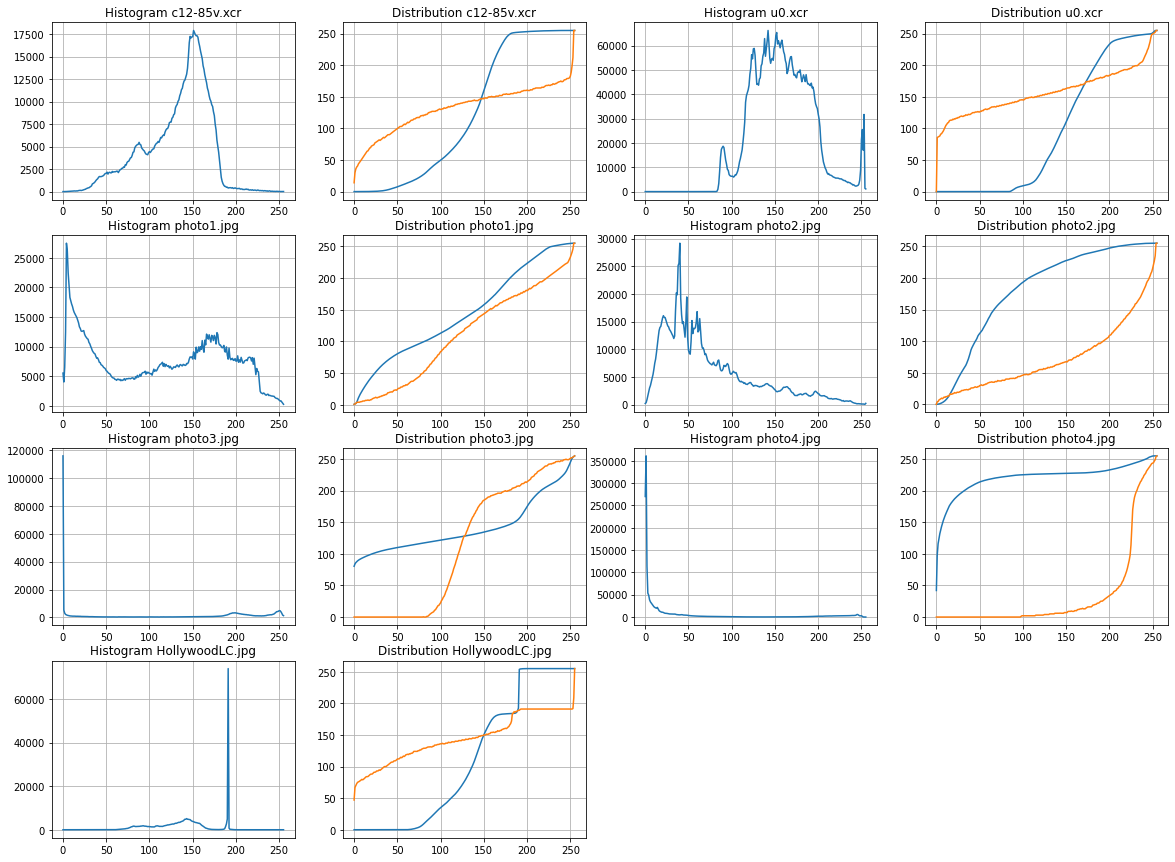

In [20]:
# Графики гистограмм и их распределений

plt.figure(figsize=(20, 15))
plt.subplot(4, 4, 1)
plt.title("Histogram c12-85v.xcr")
plt.plot(np.arange(histXray.size), histXray)
plt.grid(True)
plt.subplot(4, 4, 2)
plt.title("Distribution c12-85v.xcr")
plt.plot(np.arange(distXray.size), distXray)
plt.plot(np.arange(invXray.size), invXray)
plt.grid(True)
plt.subplot(4, 4, 3)
plt.title("Histogram u0.xcr")
plt.plot(np.arange(histXray2.size), histXray2)
plt.grid(True)
plt.subplot(4, 4, 4)
plt.title("Distribution u0.xcr")
plt.plot(np.arange(distXray2.size), distXray2)
plt.plot(np.arange(invXray2.size), invXray2)
plt.grid(True)
plt.subplot(4, 4, 5)
plt.title("Histogram photo1.jpg")
plt.plot(np.arange(histPhoto1.size), histPhoto1)
plt.grid(True)
plt.subplot(4, 4, 6)
plt.title("Distribution photo1.jpg")
plt.plot(np.arange(distPhoto1.size), distPhoto1)
plt.plot(np.arange(invPhoto1.size), invPhoto1)
plt.grid(True)
plt.subplot(4, 4, 7)
plt.title("Histogram photo2.jpg")
plt.plot(np.arange(histPhoto2.size), histPhoto2)
plt.grid(True)
plt.subplot(4, 4, 8)
plt.title("Distribution photo2.jpg")
plt.plot(np.arange(distPhoto2.size), distPhoto2)
plt.plot(np.arange(invPhoto2.size), invPhoto2)
plt.grid(True)
plt.subplot(4, 4, 9)
plt.title("Histogram photo3.jpg")
plt.plot(np.arange(histPhoto3.size), histPhoto3)
plt.grid(True)
plt.subplot(4, 4, 10)
plt.title("Distribution photo3.jpg")
plt.plot(np.arange(distPhoto3.size), distPhoto3)
plt.plot(np.arange(invPhoto3.size), invPhoto3)
plt.grid(True)
plt.subplot(4, 4, 11)
plt.title("Histogram photo4.jpg")
plt.plot(np.arange(histPhoto4.size), histPhoto4)
plt.grid(True)
plt.subplot(4, 4, 12)
plt.title("Distribution photo4.jpg")
plt.plot(np.arange(distPhoto4.size), distPhoto4)
plt.plot(np.arange(invPhoto4.size), invPhoto4)
plt.grid(True)
plt.subplot(4, 4, 13)
plt.title("Histogram HollywoodLC.jpg")
plt.plot(np.arange(histHollywood.size), histHollywood)
plt.grid(True)
plt.subplot(4, 4, 14)
plt.title("Distribution HollywoodLC.jpg")
plt.plot(np.arange(distHollywood.size), distHollywood)
plt.plot(np.arange(invHollywood.size), invHollywood)
plt.grid(True)

In [21]:
# Эквализация

imgXray.equalization(distXray)
imgXray.scale()
imgXray.save("Фото/xray/xray + equal.jpg", "JPEG")

imgXray2.equalization(distXray2)
imgXray2.scale()
imgXray2.save("Фото/xray2/xray2 + equal.jpg", "JPEG")

imgPhoto1.equalization(distPhoto1)
imgPhoto1.scale()
imgPhoto1.save("Фото/photo1/photo1 + equal.jpg", "JPEG")

imgPhoto2.equalization(distPhoto2)
imgPhoto2.scale()
imgPhoto2.save("Фото/photo2/photo2 + equal.jpg", "JPEG")

imgPhoto3.equalization(distPhoto3)
imgPhoto3.scale()
imgPhoto3.save("Фото/photo3/photo3 + equal.jpg", "JPEG")

imgPhoto4.equalization(distPhoto4)
imgPhoto4.scale()
imgPhoto4.save("Фото/photo4/photo4 + equal.jpg", "JPEG")

imgHollywood.equalization(distHollywood)
imgHollywood.scale()
imgHollywood.save("Фото/hollywood/HollywoodLC + equal.jpg", "JPEG")

In [22]:
# Приведение гистограммы

img = Image("Фото/xray/xray + swap + scale.jpg")
img.equalization(invXray)
img.scale()
img.save("Фото/xray/xray + lin.jpg", "JPEG")

img = Image("Фото/xray2/xray2 + swap + scale.jpg")
img.equalization(invXray2)
img.scale()
img.save("Фото/xray2/xray2 + lin.jpg", "JPEG")

img = Image("Фото/photo1/photo1.jpg")
img.equalization(invPhoto1)
img.scale()
img.save("Фото/photo1/photo1 + lin.jpg", "JPEG")

img = Image("Фото/photo2/photo2.jpg")
img.equalization(invPhoto2)
img.scale()
img.save("Фото/photo2/photo2 + lin.jpg", "JPEG")

img = Image("Фото/photo3/photo3.jpg")
img.equalization(invPhoto3)
img.scale()
img.save("Фото/photo3/photo3 + lin.jpg", "JPEG")

img = Image("Фото/photo4/photo4.jpg")
img.equalization(invPhoto4)
img.scale()
img.save("Фото/photo4/photo4 + lin.jpg", "JPEG")

img = Image("Фото/hollywood/HollywoodLC.jpg")
img.equalization(invHollywood)
img.scale()
img.save("Фото/hollywood/HollywoodLC + lin.jpg", "JPEG")

<h4><b>Задание 6:</b></h4>

<h6><b>Фильтрация c12-85v.xcr:</b></h6>

In [23]:
# Поиск максимумов в спектрах авто- и взаимных корреляций производных

step = 200 # шаг

imgXray = Image("Фото/xray/xray + swap + scale + rotate.jpg")
derXray = imgXray.make_derivatives(step)

autoCorrXray = imgXray.make_auto_corr(derXray)
spectraXray = imgXray.get_fourier_spectra(autoCorrXray)
spikesXray = imgXray.get_fourier_spikes(spectraXray)
print("Максимумы спектров автокорреляций производных:", spikesXray)

corrXray = imgXray.make_corr(derXray)
spectraXray = imgXray.get_fourier_spectra(corrXray)
spikesXray = imgXray.get_fourier_spikes(spectraXray)
print("Максимумы спектров взаимных корреляций производных:", spikesXray)

Максимумы спектров автокорреляций производных: [0.29521017 0.29521017 0.29521017 0.29521017 0.29423265 0.29423265]
Максимумы спектров взаимных корреляций производных: [0.29521017 0.29521017 0.29521017 0.29423265 0.29423265]


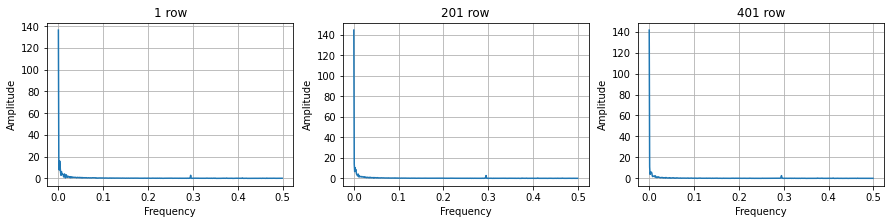

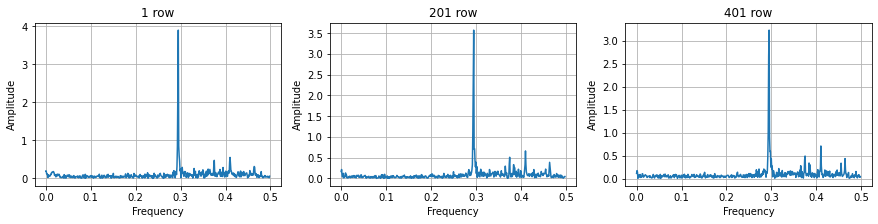

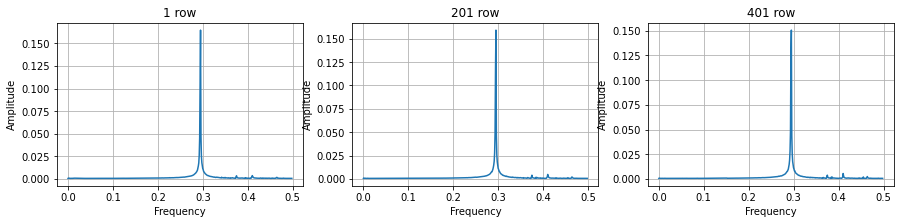

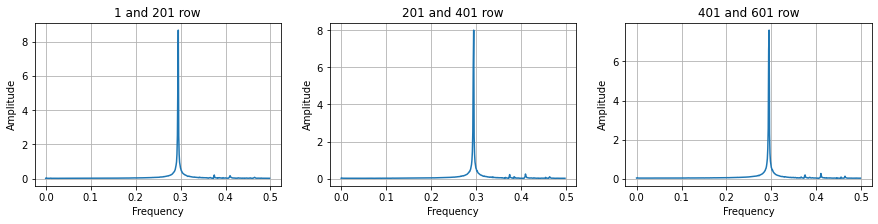

In [24]:
# Отображение спектров

n = 3 # количество графиков

# Спектры исходных строк изображения
plt.figure(figsize=(15, 3))
for i in range(n):
    func = Function(0, imgXray.width, 1)
    func.Y = imgXray.pixels[int(i * step)]
    fourier = Function(0, imgXray.width, 1)
    fourier.fourier_transform(func, 1, 1, False, True)
    fourier.X = fourier.X / imgXray.width
    plt.subplot(1, 3, i + 1)
    fourier.display(str(i * step + 1) + " row", "Frequency", "Amplitude")

# Спектры производных строк изображения
plt.figure(figsize=(15, 3))
for i in range(n):
    func = Function(0, derXray.shape[1], 1)
    func.Y = derXray[i]
    fourier = Function(0, derXray.shape[1], 1)
    fourier.fourier_transform(func, 1, 1, False, True)
    fourier.X = fourier.X / imgXray.width
    plt.subplot(1, n, i + 1)
    fourier.display(str(i * step + 1) + " row", "Frequency", "Amplitude")

# Спектры автокорреляций производных
plt.figure(figsize=(15, 3))
for i in range(n):
    func = Function(0, autoCorrXray.shape[1], 1)
    func.Y = autoCorrXray[i]
    fourier = Function(0, autoCorrXray.shape[1], 1)
    fourier.fourier_transform(func, 1, 1, False, True)
    fourier.X = fourier.X / imgXray.width
    plt.subplot(1, n, i + 1)
    fourier.display(str(i * step + 1) + " row", "Frequency", "Amplitude")
    
# Спектры взаимных корреляций производных
plt.figure(figsize=(15, 3))
for i in range(n):
    func = Function(0, corrXray.shape[1], 1)
    func.Y = corrXray[i]
    fourier = Function(0, corrXray.shape[1], 1)
    fourier.fourier_transform(func, 1, 1, False, True)
    fourier.X = fourier.X / imgXray.width
    plt.subplot(1, n, i + 1)
    fourier.display(str(i * step + 1) + " and " + str((i + 1) * step + 1) + " row", "Frequency", "Amplitude")

In [25]:
# Фильтрация изображения c12-85v.xcr

bottom = 0.25 # нижняя частота
top = 0.31 # верхняя частота
m = 32 # параметр фильтрации (длина фильтра)

imgXray.filter_image(3, m, bottom, top)
imgXray.save("Фото/xray/xray + filter.jpg", "JPEG")

<h6><b>Фильтрация u0.xcr:</b></h6>

In [26]:
# Поиск максимумов в спектрах авто- и взаимных корреляций производных

step = 200 # шаг

imgXray2 = Image("Фото/xray2/xray2 + swap + scale + rotate.jpg")
derXray2 = imgXray2.make_derivatives(step)

autoCorrXray2 = imgXray2.make_auto_corr(derXray2)
spectraXray2 = imgXray2.get_fourier_spectra(autoCorrXray2)
spikesXray2 = imgXray2.get_fourier_spikes(spectraXray2)
print("Максимумы спектров автокорреляций производных:", spikesXray2)

corrXray2 = imgXray2.make_corr(derXray2)
spectraXray2 = imgXray2.get_fourier_spectra(corrXray2)
spikesXray2 = imgXray2.get_fourier_spikes(spectraXray2)
print("Максимумы спектров взаимных корреляций производных:", spikesXray2)

Максимумы спектров автокорреляций производных: [0.00480192 0.39255702 0.00720288 0.00320128 0.00240096 0.00240096
 0.00240096 0.00160064 0.4889956  0.38895558 0.38535414]
Максимумы спектров взаимных корреляций производных: [0.00120048 0.01320528 0.00320128 0.00240096 0.00240096 0.00240096
 0.00160064 0.00160064 0.00320128 0.38535414]


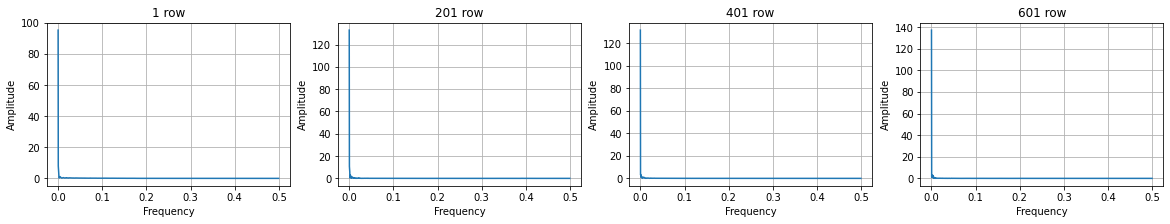

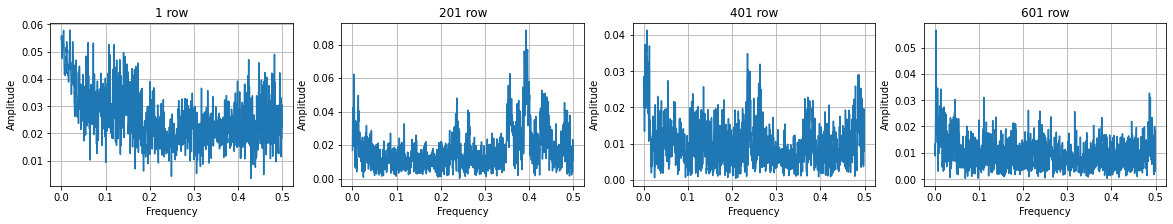

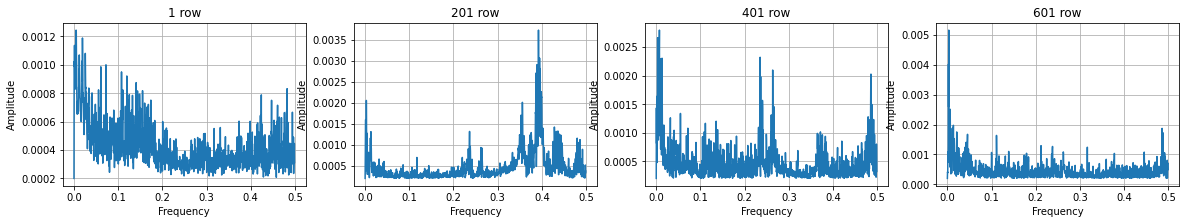

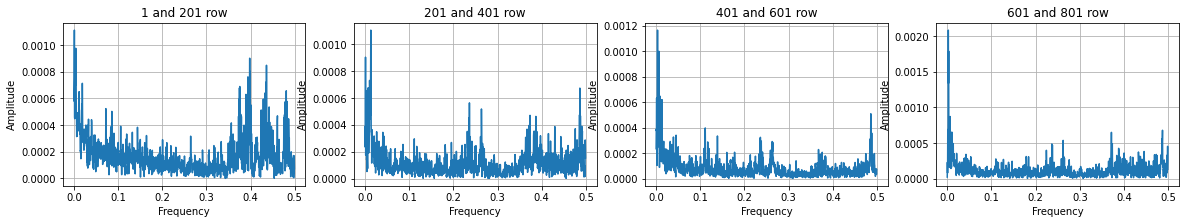

In [27]:
# Отображение спектров

n = 4 # количество графиков

# Спектры исходных строк изображения
plt.figure(figsize=(20, 3))
for i in range(n):
    func = Function(0, imgXray2.width, 1)
    func.Y = imgXray2.pixels[int(i * step)]
    fourier = Function(0, imgXray2.width, 1)
    fourier.fourier_transform(func, 1, 1, False, True)
    fourier.X = fourier.X / imgXray2.width
    plt.subplot(1, n, i + 1)
    fourier.display(str(i * step + 1) + " row", "Frequency", "Amplitude")

# Спектры производных строк изображения
plt.figure(figsize=(20, 3))
for i in range(n):
    func = Function(0, derXray2.shape[1], 1)
    func.Y = derXray2[i]
    fourier = Function(0, derXray2.shape[1], 1)
    fourier.fourier_transform(func, 1, 1, False, True)
    fourier.X = fourier.X / imgXray2.width
    plt.subplot(1, n, i + 1)
    fourier.display(str(i * step + 1) + " row", "Frequency", "Amplitude")

# Спектры автокорреляций производных
plt.figure(figsize=(20, 3))
for i in range(n):
    func = Function(0, autoCorrXray2.shape[1], 1)
    func.Y = autoCorrXray2[i]
    fourier = Function(0, autoCorrXray2.shape[1], 1)
    fourier.fourier_transform(func, 1, 1, False, True)
    fourier.X = fourier.X / imgXray2.width
    plt.subplot(1, n, i + 1)
    fourier.display(str(i * step + 1) + " row", "Frequency", "Amplitude")
    
# Спектры взаимных корреляций производных
plt.figure(figsize=(20, 3))
for i in range(n):
    func = Function(0, corrXray2.shape[1], 1)
    func.Y = corrXray2[i]
    fourier = Function(0, corrXray2.shape[1], 1)
    fourier.fourier_transform(func, 1, 1, False, True)
    fourier.X = fourier.X / imgXray2.width
    plt.subplot(1, n, i + 1)
    fourier.display(str(i * step + 1) + " and " + str((i + 1) * step + 1) + " row", "Frequency", "Amplitude")

<h4><b>Задание 7:</b></h4>

In [28]:
# Шум типа соль и перец

n = 30 # количество испорченных пикселей на строку

imgModel = Image("Фото/model/model.jpg")
imgModel.make_SnP(n)
imgModel.save("Фото/model/model + s&p.jpg", "JPEG")

In [29]:
# Случайный шум

scale = 20 # диапазон случайной величины

imgModel = Image("Фото/model/model.jpg")
imgModel.make_rand(scale)
imgModel.save("Фото/model/model + rand.jpg", "JPEG")

In [30]:
# Смесь двух типов шумов

n = 10 # количество испорченных пикселей на строку
scale = 20 # диапазон случайной величины

imgModel = Image("Фото/model/model.jpg")
imgModel.make_SnP(n)
imgModel.make_rand(scale)
imgModel.save("Фото/model/model + s&p + rand.jpg", "JPEG")

In [31]:
# Подавление шума усредняющим фильтром

n = 11 # размер маски

imgModel = Image("Фото/model/model + s&p + rand.jpg")
imgModel.apply_masks([imgModel.do_single_mask(n)])
imgModel.pixels = imgModel.pixels / (n * n)
imgModel.save("Фото/model/model + avg filter 11.jpg", "JPEG")

In [32]:
# Подавление шума медианным фильтром

maskSize = 11 # размер маски

imgModel = Image("Фото/model/model + s&p + rand.jpg")
imgModel.median_filter(maskSize)
imgModel.save("Фото/model/model + med filter 11.jpg", "JPEG")

<h4><b>Задание 8:</b></h4>

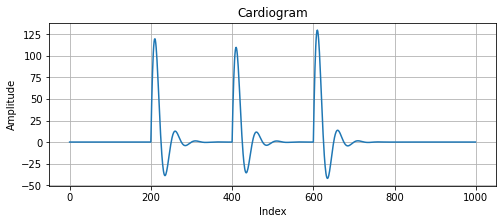

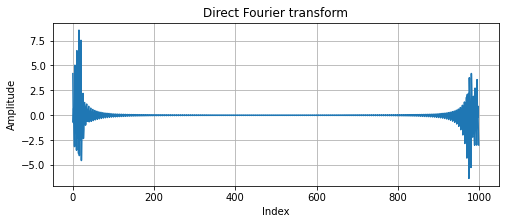

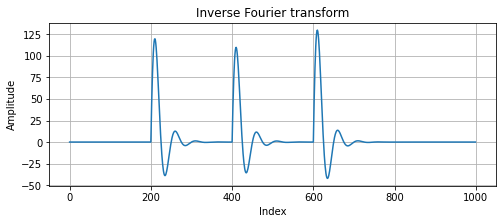

In [33]:
N = 1000 # количество значений в входном сигнале
M = 200 # количество значений в функции h
start = 0 # начальное значение
step = 1 # шаг по умолчанию
dt = 0.005 # шаг дискретизации

A = 10 # амплитуда гармонического процесса
f = 4 # частота
# параметры экспоненты
a = 9
b = 1

# Входной сигнал
x = Function(start, N, step)
x.Y[200] = 120
x.Y[400] = 110
x.Y[600] = 130

# Мультипликативная функция h
funcExp = Function(start, M * dt, dt)
funcExp.exp(a, b)
funcSin = Function(start, M * dt, dt)
funcSin.sin(A, f)
h = Function(start, M * dt, dt)
h.multiply_func([funcExp, funcSin])
h.normalize()

# Каридограмма (функция свёртки)
funcCard = Function(start, N, step)
funcCard.convolution_func(x, h)
plt.figure(figsize=(8, 3))
funcCard.display('Cardiogram', 'Index', 'Amplitude')

# Прямое преобразование Фурье
funcFourier = Function(start, N, step)
funcFourier.fourier_transform(funcCard, 1, 2, False, False, dt)
plt.figure(figsize=(8, 3))
funcFourier.display('Direct Fourier transform', 'Index', 'Amplitude')

# Обратное преобразование Фурье
funcInvFourier = Function(start, N, step)
funcInvFourier.fourier_transform(funcFourier, 1, 3, False, False, dt)
plt.figure(figsize=(8, 3))
funcInvFourier.display('Inverse Fourier transform', 'Index', 'Amplitude')

In [34]:
# 2D амплитудный спектр Фурье для grace.jpg

imgGrace = Image("Фото/grace/grace.jpg")
imgGrace.fourier_transform_2D(1)
imgGrace.log_transform(20)
imgGrace.scale()
imgGrace.save("Фото/grace/grace + amp fourier.jpg", "JPEG")

In [35]:
# 2D прямое и обратное преобразования Фурье для grace.jpg

imgGrace = Image("Фото/grace/grace.jpg")
imgGrace.fourier_transform_2D(2)
imgGrace.fourier_transform_2D(3)
imgGrace.save("Фото/grace/grace + inv.jpg", "JPEG")

In [36]:
# Увеличение grace.jpg методом прямого преобразования Фурье

coeff = 1.3 # коэффициент увеличения

imgGrace = Image("Фото/grace/grace.jpg")
imgGrace.resize_F(coeff)
imgGrace.scale()
imgGrace.save("Фото/grace/grace + resize F.jpg", "JPEG")

In [37]:
# Вычитание из оригинального grace.jpg увеличенных разными способами копий

imgGrace = Image("Фото/grace/grace2.jpg")
imgGraceNNM = Image("Фото/grace/grace + resize NNM.jpg")
imgGraceBI = Image("Фото/grace/grace + resize BI.jpg")
imgGraceF = Image("Фото/grace/grace + resize F.jpg")

imgGraceNNM.pixels = imgGrace.pixels - imgGraceNNM.pixels
imgGraceNNM.scale()
imgGraceNNM.save("Фото/grace/grace - NNM.jpg", "JPEG")
imgGraceBI.pixels = imgGrace.pixels - imgGraceBI.pixels
imgGraceBI.scale()
imgGraceBI.save("Фото/grace/grace - BI.jpg", "JPEG")
imgGraceF.pixels = imgGrace.pixels - imgGraceF.pixels
imgGraceF.scale()
imgGraceF.save("Фото/grace/grace - F.jpg", "JPEG")

In [38]:
# Градационные преобразования разностных изображений

imgGraceNNM = Image("Фото/grace/grace - NNM.jpg")
imgGraceBI = Image("Фото/grace/grace - BI.jpg")
imgGraceF = Image("Фото/grace/grace - F.jpg")

imgGraceNNM.power_transform(10, 0.5)
imgGraceNNM.scale()
imgGraceNNM.save("Фото/grace/grace - NNM 2.jpg", "JPEG")
imgGraceBI.power_transform(10, 0.5)
imgGraceBI.scale()
imgGraceBI.save("Фото/grace/grace - BI 2.jpg", "JPEG")
imgGraceF.power_transform(10, 0.5)
imgGraceF.scale()
imgGraceF.save("Фото/grace/grace - F 2.jpg", "JPEG")

<h4><b>Задание 9:</b></h4>

In [39]:
# Отображение blur307x221D.dat

imgBlur = Image("Фото/blur/blur307x221D.dat", 307, 221)
imgBlur.scale()
imgBlur.save("Фото/blur/blur.jpg", "JPEG")

# Отображение blur307x221D_N.dat

imgBlur_N = Image("Фото/blur/blur307x221D_N.dat", 307, 221)
imgBlur_N.scale()
imgBlur_N.save("Фото/blur/blur_N.jpg", "JPEG")

In [40]:
# Восстановление blur307x221D.dat

imgBlur = Image("Фото/blur/blur307x221D.dat", 307, 221)
imgKern = Image("Фото/blur/kernD76_f4.dat", 76, 1)
imgKern.set_zeros(307, 1)
imgBlur.recover_image(imgKern.pixels[0, :])
imgBlur.scale()
imgBlur.save("Фото/blur/blur + restore.jpg", "JPEG")

In [41]:
# Восстановление blur307x221D_N.dat

alpha2 = 0.0001 # добавка [0..1]

imgBlur = Image("Фото/blur/blur307x221D_N.dat", 307, 221)
imgKern = Image("Фото/blur/kernD76_f4.dat", 76, 1)
imgKern.set_zeros(307, 1)
imgBlur.recover_image(imgKern.pixels[0, :], alpha2)
imgBlur.scale()
imgBlur.save("Фото/blur/blur_N + restore.jpg", "JPEG")

<h4><b>Задание 10:</b></h4>

<h6><b>Фильтр высоких частот:</b></h6>

In [42]:
threshold1 = 200 # порог 1
freq = 0.97 # частота
m = 64 # параметр фильтрации (длина фильтра)

# model.jpg

threshold2 = 45 # порог 2

imgModel = Image("Фото/model/model.jpg")
imgModel.threshold_filter(threshold1)
imgModel.filter_image(2, m, freq)
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + filter HPF.jpg", "JPEG")

# Зашумлённое model.jpg

threshold2 = 65 # порог 2

imgModel = Image("Фото/model/model + s&p + rand.jpg")
imgModel.threshold_filter(threshold1)
imgModel.filter_image(2, m, freq)
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + rand + filter HPF.jpg", "JPEG")

# Восстановленное фильтром арифметического среднего model.jpg

threshold2 = 55 # порог 2

imgModel = Image("Фото/model/model + avg filter 11.jpg")
imgModel.threshold_filter(threshold1)
imgModel.filter_image(2, m, freq)
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + avg + filter HPF.jpg", "JPEG")

# Восстановленное медианным фильтром model.jpg

threshold2 = 65 # порог 2

imgModel = Image("Фото/model/model + med filter 5.jpg")
imgModel.threshold_filter(threshold1)
imgModel.filter_image(2, m, freq)
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + med + filter HPF.jpg", "JPEG")

<h6><b>Фильтр низких частот:</b></h6>

In [43]:
threshold1 = 200 # порог 1
freq = 0.03 # частота
m = 64 # параметр фильтрации (длина фильтра)

# model.jpg

threshold2 = 45 # порог 2

imgModel = Image("Фото/model/model.jpg")
imgModel.threshold_filter(threshold1)
pixelsBeforeFilter = imgModel.pixels.copy()
imgModel.filter_image(1, m, freq)
imgModel.pixels = imgModel.pixels - pixelsBeforeFilter
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + filter LPF.jpg", "JPEG")

# Зашумлённое model.jpg

threshold2 = 45 # порог 2

imgModel = Image("Фото/model/model + s&p + rand.jpg")
imgModel.threshold_filter(threshold1)
pixelsBeforeFilter = imgModel.pixels.copy()
imgModel.filter_image(1, m, freq)
imgModel.pixels = imgModel.pixels - pixelsBeforeFilter
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + rand + filter LPF.jpg", "JPEG")

# Восстановленное фильтром арифметического среднего model.jpg

threshold2 = 55 # порог 2

imgModel = Image("Фото/model/model + avg filter 11.jpg")
imgModel.threshold_filter(threshold1)
pixelsBeforeFilter = imgModel.pixels.copy()
imgModel.filter_image(1, m, freq)
imgModel.pixels = imgModel.pixels - pixelsBeforeFilter
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + avg + filter LPF.jpg", "JPEG")

# Восстановленное медианным фильтром model.jpg

threshold2 = 65 # порог 2

imgModel = Image("Фото/model/model + med filter 5.jpg")
imgModel.threshold_filter(threshold1)
pixelsBeforeFilter = imgModel.pixels.copy()
imgModel.filter_image(1, m, freq)
imgModel.pixels = imgModel.pixels - pixelsBeforeFilter
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + med + filter LPF.jpg", "JPEG")

<h4><b>Задание 11:</b></h4>

<h6><b>Обычный градиент:</b></h6>

In [44]:
threshold1 = 200 # порог 1
threshold2 = 100 # порог 2
masks = [np.array([[0, 0, 0], [0, -1, 0], [0, 1, 0]]), np.array([[0, 0, 0], [0, -1, 1], [0, 0, 0]])]

# model.jpg

imgModel = Image("Фото/model/model.jpg")
imgModel.threshold_filter(threshold1)
imgModel.apply_masks(masks)
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + gradient.jpg", "JPEG")

# Зашумдённое model.jpg

imgModel = Image("Фото/model/model + s&p + rand.jpg")
imgModel.threshold_filter(threshold1)
imgModel.apply_masks(masks)
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + rand + gradient.jpg", "JPEG")

# Восстановленное фильтром арифметического среднего model.jpg

imgModel = Image("Фото/model/model + avg filter 11.jpg")
imgModel.threshold_filter(threshold1)
imgModel.apply_masks(masks)
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + avg + gradient.jpg", "JPEG")

# Восстановленное медианным фильтром model.jpg

imgModel = Image("Фото/model/model + med filter 5.jpg")
imgModel.threshold_filter(threshold1)
imgModel.apply_masks(masks)
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + med + gradient.jpg", "JPEG")

<h6><b>Маски Собела по вертикали и горизонтали:</b></h6>

In [45]:
threshold1 = 200 # порог 1
threshold2 = 100 # порог 2
masks = [np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]), np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])]

# model.jpg

imgModel = Image("Фото/model/model.jpg")
imgModel.threshold_filter(threshold1)
imgModel.apply_masks(masks)
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + sobel 1.jpg", "JPEG")

# Зашумдённое model.jpg

imgModel = Image("Фото/model/model + s&p + rand.jpg")
imgModel.threshold_filter(threshold1)
imgModel.apply_masks(masks)
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + rand + sobel 1.jpg", "JPEG")

# Восстановленное фильтром арифметического среднего model.jpg

imgModel = Image("Фото/model/model + avg filter 11.jpg")
imgModel.threshold_filter(threshold1)
imgModel.apply_masks(masks)
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + avg + sobel 1.jpg", "JPEG")

# Восстановленное медианным фильтром model.jpg

imgModel = Image("Фото/model/model + med filter 5.jpg")
imgModel.threshold_filter(threshold1)
imgModel.apply_masks(masks)
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + med + sobel 1.jpg", "JPEG")

<h6><b>Маски Собела по диагонали:</b></h6>

In [46]:
threshold1 = 200 # порог 1
threshold2 = 100 # порог 2
masks = [np.array([[0, 1, 2], [-1, 0, 1], [-2, -1, 0]]), np.array([[-2, -1, 0], [-1, 0, 1], [0, 1, 2]])]

# model.jpg

imgModel = Image("Фото/model/model.jpg")
imgModel.threshold_filter(threshold1)
imgModel.apply_masks(masks)
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + sobel 2.jpg", "JPEG")

# Зашумдённое model.jpg

imgModel = Image("Фото/model/model + s&p + rand.jpg")
imgModel.threshold_filter(threshold1)
imgModel.apply_masks(masks)
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + rand + sobel 2.jpg", "JPEG")

# Восстановленное фильтром арифметического среднего model.jpg

imgModel = Image("Фото/model/model + avg filter 11.jpg")
imgModel.threshold_filter(threshold1)
imgModel.apply_masks(masks)
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + avg + sobel 2.jpg", "JPEG")

# Восстановленное медианным фильтром model.jpg

imgModel = Image("Фото/model/model + med filter 5.jpg")
imgModel.threshold_filter(threshold1)
imgModel.apply_masks(masks)
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + med + sobel 2.jpg", "JPEG")

<h6><b>Лапласиан:</b></h6>

In [47]:
threshold1 = 200 # порог 1
threshold2 = 100 # порог 2
masks = [np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])]

# model.jpg

imgModel = Image("Фото/model/model.jpg")
imgModel.threshold_filter(threshold1)
imgModel.apply_masks(masks)
imgModel.pixels = np.abs(imgModel.pixels)
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + laplas.jpg", "JPEG")

# Зашумдённое model.jpg

imgModel = Image("Фото/model/model + s&p + rand.jpg")
imgModel.threshold_filter(threshold1)
imgModel.apply_masks(masks)
imgModel.pixels = np.abs(imgModel.pixels)
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + rand + laplas.jpg", "JPEG")

# Восстановленное фильтром арифметического среднего model.jpg

imgModel = Image("Фото/model/model + avg filter 11.jpg")
imgModel.threshold_filter(threshold1)
imgModel.apply_masks(masks)
imgModel.pixels = np.abs(imgModel.pixels)
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + avg + laplas.jpg", "JPEG")

# Восстановленное медианным фильтром model.jpg

imgModel = Image("Фото/model/model + med filter 5.jpg")
imgModel.threshold_filter(threshold1)
imgModel.apply_masks(masks)
imgModel.pixels = np.abs(imgModel.pixels)
imgModel.threshold_filter(threshold2)
imgModel.save("Фото/model/model + med + laplas.jpg", "JPEG")